In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wasserstein_distance
from mood.distance import compute_knn_distance

In [2]:
def generate_cluster(
    rng, 
    center: tuple = None, 
    x_size: float = 1, 
    y_size: float = 1, 
    x_noise_level: float = 0, 
    y_noise_level: float = 0, 
    fix_r: float = None,
    n: int = 1000
):
    
    if center is None: 
        center = (0, 0)

    phi = rng.random(n) * np.pi * 2
    
    if fix_r is None:
        r = np.sqrt(rng.random(n))
    else: 
        r = np.array([fix_r] * n)
    
    x_noise = (rng.random(n) * 2 - 1) * x_noise_level
    y_noise = (rng.random(n) * 2 - 1) * y_noise_level
    
    x = center[0] + r * x_size * np.cos(phi) + x_noise
    y = center[1] + r * y_size * np.sin(phi) + y_noise
    
    return x, y

In [3]:
rng = np.random.default_rng(42)

x_1, y_1 = generate_cluster(rng, (-1, 0), x_size=1.5, y_size=1.5, n=50)
x_2, y_2 = generate_cluster(rng, center=(-3, 1.5), x_size=1, n=50)
x_3, y_3 = generate_cluster(rng, center=(-2.5, -2), x_size=0.5, n=50)

x_4, y_4 = generate_cluster(rng, (1.5, 1), n=500, x_size=0.5, y_noise_level=1, x_noise_level=0.5)

In [4]:
cmap = sns.color_palette("Set2")
cmap

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

/tmp/ipykernel_6302/1214212416.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, s=25, c=c, ax=ax, palette=cmap)


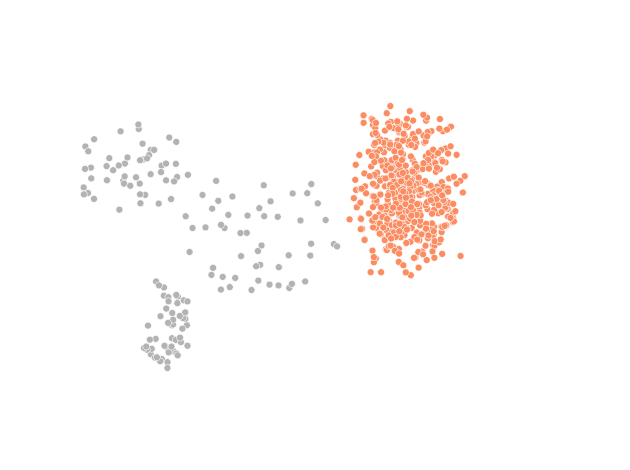

In [5]:
x = np.concatenate((x_1, x_2, x_3, x_4))
y = np.concatenate((y_1, y_2, y_3, y_4))
c = [cmap[-1]] * (len(x_1) + len(x_2) + len(x_3)) + [cmap[1]] * len(x_4)

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, s=25, c=c, ax=ax, palette=cmap)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis("off")

plt.tight_layout()
plt.savefig("scatter_app.png", bbox_inches='tight', transparent=True)

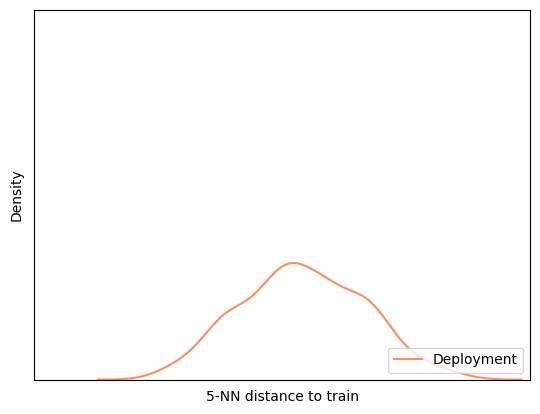

In [6]:
coords_1 = np.stack((np.concatenate((x_1, x_2, x_3)), np.concatenate((y_1, y_2, y_3))), axis=-1)
coords_2 = np.stack((x_4, y_4), axis=-1)

dist_1, dist_2 = compute_knn_distance(coords_1, [coords_1, coords_2])

fig, ax = plt.subplots()
sns.kdeplot(dist_2, ax=ax, color=cmap[1], label="Deployment")
ax.set_xlabel("5-NN distance to train")
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc="lower right")

ax.set_xlim((-0.2, 3.25))
ax.set_ylim((0, 2.75))
plt.savefig("density_app.png", bbox_inches='tight')

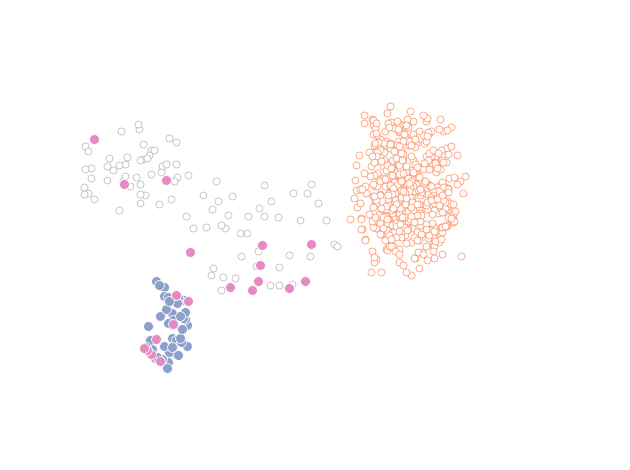

In [7]:
x = np.concatenate((x_1, x_2, x_3))
y = np.concatenate((y_1, y_2, y_3))

random_ind = rng.permutation(np.arange(len(x)))
rand_x = x[random_ind[:20]]
rand_y = y[random_ind[:20]]

rand_x_train = x[random_ind[20:]]
rand_y_train = y[random_ind[20:]]

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, s=25, edgecolor=cmap[-1], linewidth=0.5, facecolor="white")
sns.scatterplot(x=x_3, y=y_3, s=50, color=cmap[2], ax=ax)
sns.scatterplot(x=rand_x, y=rand_y, s=50, color=cmap[3], ax=ax)
sns.scatterplot(x=x_4, y=y_4, s=25, edgecolor=cmap[1], linewidth=0.5, facecolor="white")

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis("off")

plt.tight_layout()
plt.savefig("scatter_split.png", bbox_inches='tight', transparent=True)

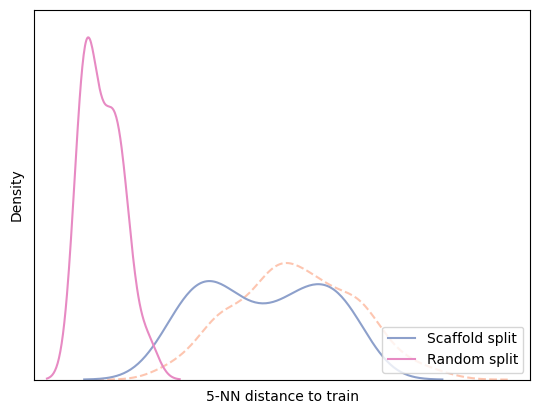

In [8]:
x = np.concatenate((x_1, x_2))
y = np.concatenate((y_1, y_2))
coords3 = np.stack((x, y), axis=-1)

coords4 = np.stack((x_3, y_3), axis=-1)
dist_4 = compute_knn_distance(coords3, coords4)

coords5 = np.stack((rand_x_train, rand_y_train), axis=-1)
coords6 = np.stack((rand_x, rand_y), axis=-1)
dist_5 = compute_knn_distance(coords5, coords6)

fig, ax = plt.subplots()
sns.kdeplot(dist_2, ax=ax, color=cmap[1], linestyle="--", alpha=0.5)
sns.kdeplot(dist_4, ax=ax, c=cmap[2], label="Scaffold split")
sns.kdeplot(dist_5, ax=ax, c=cmap[3], label="Random split")

ax.set_xlabel("5-NN distance to train")
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc="lower right")
ax.set_xlim((-0.2, 3.35))
ax.set_ylim((0, 2.75))

plt.savefig("density_split.png", bbox_inches='tight')

In [9]:
wasserstein_distance(dist_2, dist_4)

0.22878817680320204

In [10]:
wasserstein_distance(dist_2, dist_5)

1.380802679346246

The End. 